# **Практика 4**

Студент группы ИКБО-27-22
Соловьев Иван Евгеньевич

# Импорты

In [2]:
import numpy as np
from scipy.stats import f_oneway, ttest_ind, pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Задание 1
Определить два вектора, представляющие собой число автомобилей, припаркованных в течении 5 рабочих дней у бизнес-центра на уличной стоянке и в подземном гараже. 

In [7]:
street = np.array([80, 98, 75, 91, 78])
garage = np.array([100, 82, 105, 89, 102])

print(street, garage)

[80 98 75 91 78] [100  82 105  89 102]


## Задание 1.1
Найти и интерпретировать корреляцию между переменными «Улица» и «Гараж» (подсчитать корреляцию по Пирсону).

In [8]:
corr, p_value = pearsonr(street, garage)

print(f"Коэффициент корреляции Пирсона: {corr:.3f}")
print(f"P-значение: {p_value:.4f}")

Коэффициент корреляции Пирсона: -1.000
P-значение: 0.0000


# Вывод

1. Коэффициент корреляции, приближающийся к -1, свидетельствует о практически идеальной обратной связи: чем больше машин на улице, тем меньше их в гараже, и наоборот.

2. Нулевое p-значение (p = 0.0000) статистически подтверждает, что обнаруженная зависимость не является случайной.

## Задание 1.2
Построить диаграмму рассеяния для вышеупомянутых переменных.

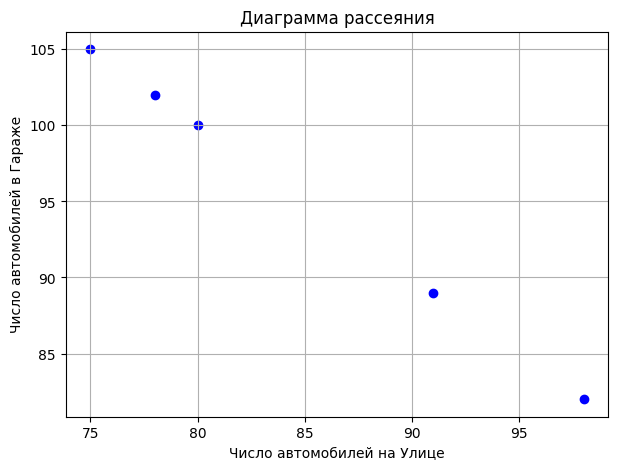

In [9]:
plt.figure(figsize=(7, 5))
plt.scatter(street, garage, color='blue')
plt.title('Диаграмма рассеяния')
plt.xlabel('Число автомобилей на Улице')
plt.ylabel('Число автомобилей в Гараже')
plt.grid(True)
plt.show()

# Вывод

Диаграмма подтверждает выводы прошлого задания

# Задание 2
Найти и выгрузить данные. Вывести, провести предобработку и описать признаки.

In [12]:
df = pd.read_csv('Pakistan_Food_Prices_2025.csv')

# Копия
df_proc = df.copy()

# Приведение строковых колонок к единому стилю
cat_cols = ['Item', 'Category', 'City', 'Month', 'Source']
df_proc[cat_cols] = df_proc[cat_cols].apply(lambda c: c.str.strip().str.title())

# Удаление дубликатов
df_proc = df_proc.drop_duplicates()

# One-hot encoding категорий
df_proc = pd.get_dummies(df_proc, columns=cat_cols, drop_first=True)

df_proc.head()

,Price_per_Kg,Item_Banana,Item_Beef (Local),Item_Carrot,Item_Cheese (Local),Item_Chicken (Whole),Item_Chicken Breast,Item_Chickpeas,Item_Cooking Oil (Sunflower),Item_Eggplant,...,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Source_Municipal Report,Source_Online Retailer,Source_Retailer Listing,Source_Wholesale Market
0,188.93,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
1,866.60,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,243.67,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
3,121.40,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,127.83,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False


## Задание 2.1
Построить корреляционную матрицу по одной целевой переменной. Определить наиболее коррелирующую переменную, продолжить с ней работу в следующем пункте.

In [15]:
df['Month_num'] = df['Month'].map({
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
})

# Создаем бинарный признак для самого частого города
most_common_city = df['City'].value_counts().index[0]
df['Is_Most_Common_City'] = (df['City'] == most_common_city).astype(int)

# Корреляционный анализ
numerical_cols = ['Price_per_Kg', 'Month_num', 'Is_Most_Common_City']
correlation_matrix = df[numerical_cols].corr()

# Находим наиболее коррелирующую переменную с Price_per_Kg
price_corr = correlation_matrix['Price_per_Kg'].abs().sort_values(ascending=False)
most_correlated_var = price_corr.index[1]
corr_value = correlation_matrix['Price_per_Kg'][most_correlated_var]

print("Корреляция с Price_per_Kg:")
print(price_corr.drop('Price_per_Kg'))
print(f"Наиболее коррелирующая переменная: {most_correlated_var} (r = {corr_value:.3f})")

Корреляция с Price_per_Kg:
Is_Most_Common_City    0.02947
Month_num              0.02315
Name: Price_per_Kg, dtype: float64
Наиболее коррелирующая переменная: Is_Most_Common_City (r = -0.029)


## Задание 2.2
Реализовать регрессию вручную, отобразить наклон, сдвиг и MSE.

In [16]:
X_var_name = most_correlated_var
X = df[X_var_name].values
Y = df['Price_per_Kg'].values

# Наклон (m)
mean_X = np.mean(X)
mean_Y = np.mean(Y)
m = np.sum((X - mean_X) * (Y - mean_Y)) / np.sum((X - mean_X)**2)

# Сдвиг (c)
c = mean_Y - m * mean_X

# Предсказания и MSE
Y_pred = m * X + c
mse = np.mean((Y - Y_pred)**2)

print(f"Регрессия: Price_per_Kg vs {X_var_name}")
print(f"Наклон: {m:.2f}")
print(f"Сдвиг: {c:.2f}")
print(f"MSE: {mse:.2f}")

Регрессия: Price_per_Kg vs Is_Most_Common_City
Наклон: -31.80
Сдвиг: 375.56
MSE: 120449.87


# Вывод

1. Наклон: Насколько в среднем вырастет результат Y, если показатель X увеличить на 1.
2. Сдвиг: Какое среднее значение принимает Y, если X равен нулю.
3. MSE: Это мера средней величины ошибок прогноза. Меньшее значение MSE означает более высокую точность модели

## Задание 2.3
Визуализировать регрессию на графике.

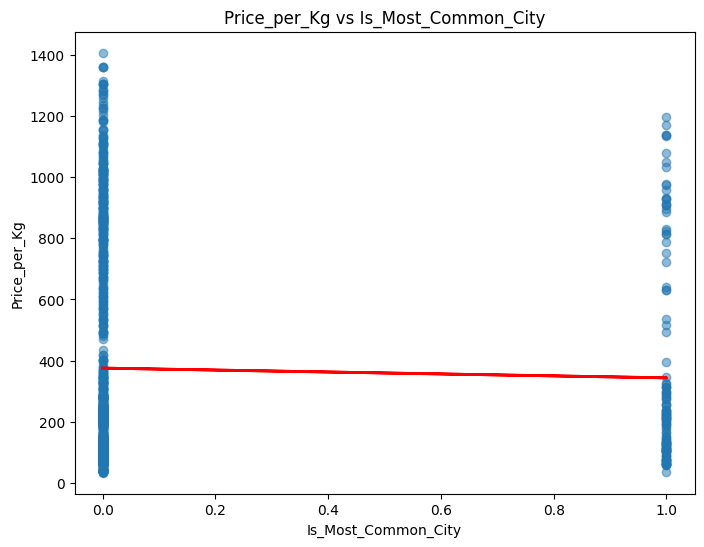

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, alpha=0.5)
plt.plot(X, Y_pred, color='red', linewidth=2)

plt.title(f'Price_per_Kg vs {X_var_name}')
plt.xlabel(X_var_name)
plt.ylabel('Price_per_Kg')
plt.show()

# Задание 3
Загрузить данные: 'insurance.csv'. Вывести и провести предобработку. Вывести список уникальных регионов. 

In [18]:
df = pd.read_csv('insurance.csv')

unique_regions = df['region'].unique()
print(f"Список уникальных регионов: {unique_regions.tolist()}")

Список уникальных регионов: ['southwest', 'southeast', 'northwest', 'northeast']


## Задание 3.1
Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя первый способ, через библиотеку Scipy.

In [19]:
regions_data = [df['bmi'][df['region'] == region].values for region in unique_regions]

f_scipy, p_scipy = f_oneway(*regions_data)
print("Однофакторный ANOVA - Влияние Региона на BMI:")
print(f"F-статистика: {f_scipy:.3f}, P-значение: {p_scipy:.4f}")

Однофакторный ANOVA - Влияние Региона на BMI:
F-статистика: 39.495, P-значение: 0.0000


## Задание 3.2
Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя второй способ, с помощью функции anova_lm() из библиотеки statsmodels

In [20]:
model_anova1 = ols('bmi ~ C(region)', data=df).fit()
anova_table1 = sm.stats.anova_lm(model_anova1, typ=2)
print("Однофакторный ANOVA (statsmodels)")
print(anova_table1)

Однофакторный ANOVA (statsmodels)
                 sum_sq      df          F        PR(>F)
C(region)   4055.880631     3.0  39.495057  1.881839e-24
Residual   45664.319755  1334.0        NaN           NaN


## Задание 3.3
С помощью t критерия Стьюдента перебрать все пары. Определить поправку Бонферрони. Сделать выводы.

In [21]:
n_regions = len(unique_regions)
n_pairs = n_regions * (n_regions - 1) // 2
alpha = 0.05 # Константая переменная

bonferroni_alpha = alpha / n_pairs # Поправка Бонферрони
print(f"T-критерий Стьюдента с поправкой Бонферрони (α/k = {bonferroni_alpha:.5f}):")

results_ttest = []
regions = df['region'].unique()
for i in range(n_regions):
    for j in range(i + 1, n_regions):
        region1 = regions[i]
        region2 = regions[j]
        data1 = df['bmi'][df['region'] == region1]
        data2 = df['bmi'][df['region'] == region2]
        t_stat, p_val = ttest_ind(data1, data2)

        is_significant = 'Да' if p_val < bonferroni_alpha else 'Нет'
        results_ttest.append({'Пара': f'{region1} vs {region2}', 'p-value': p_val, 'Значимо (Бонферрони)': is_significant})

ttest_df = pd.DataFrame(results_ttest)
print(ttest_df)
print(f"Выводы: Отклоняем поправку о равенстве средних BMI для тех пар, где p-value < {bonferroni_alpha:.5f}.")

T-критерий Стьюдента с поправкой Бонферрони (α/k = 0.00833):
                     Пара       p-value Значимо (Бонферрони)
0  southwest vs southeast  5.437401e-09                   Да
1  southwest vs northwest  1.076958e-03                   Да
2  southwest vs northeast  1.908616e-03                   Да
3  southeast vs northwest  2.643571e-19                   Да
4  southeast vs northeast  1.186015e-17                   Да
5  northwest vs northeast  9.519292e-01                  Нет
Выводы: Отклоняем поправку о равенстве средних BMI для тех пар, где p-value < 0.00833.


# Вывод

1. В 5 из 6 пар регионов средний вес людей статистически значимо отличается. Особенно большая разница между юго-восточным регионом и всеми остальными.

2. Только два региона — северо-западный и северо-восточный — имеют статистически одинаковый средний вес (p-value = 0.952). Разница между ними незначима.

3. Поправка Бонферрони подтверждает надежность результатов, так как даже при самом строгом критерии различия остаются значимыми.

## Задание 3.4
Выполнить пост-хок тесты Тьюки и построить график.

Пост-хок тест Тьюки (Однофакторный):
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
northeast northwest   0.0263 0.9999 -1.1552  1.2078  False
northeast southeast   4.1825    0.0   3.033   5.332   True
northeast southwest   1.4231 0.0107  0.2416  2.6046   True
northwest southeast   4.1562    0.0  3.0077  5.3047   True
northwest southwest   1.3968 0.0127  0.2162  2.5774   True
southeast southwest  -2.7594    0.0 -3.9079 -1.6108   True
----------------------------------------------------------


<Figure size 1000x600 with 0 Axes>

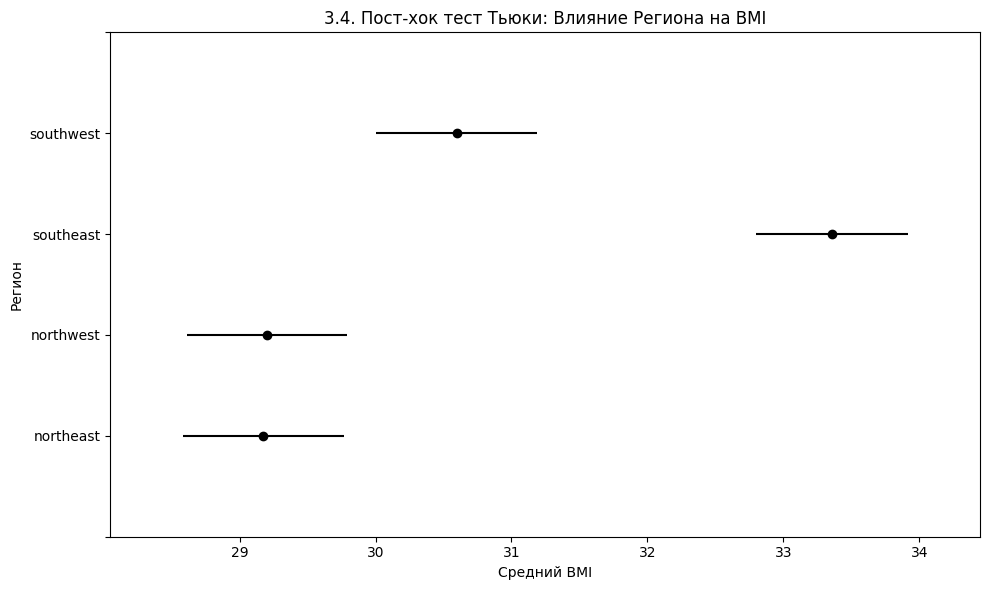

In [ ]:
tukey_oneway_result = pairwise_tukeyhsd(endog=df['bmi'], groups=df['region'], alpha=alpha)
print("Пост-хок тест Тьюки (Однофакторный):")
print(tukey_oneway_result.summary())

plt.figure(figsize=(10, 6))
tukey_oneway_result.plot_simultaneous(xlabel='Средний BMI', ylabel='Регион')
plt.title("3.4. Пост-хок тест Тьюки: Влияние Региона на BMI")
plt.tight_layout()
plt.show()

# Вывод

Пост-хок тест Тьюки подтвердил, что средний BMI значительно варьируется в зависимости от региона. В частности, регион southeast является явным статистическим выбросом с самым высоким средним BMI, который значимо отличается от всех остальных трех регионов.

## Задание 3.5
Выполнить двухфакторный ANOVA тест, чтобы проверить влияние региона и пола на индекс массы тела (BMI), используя функцию anova_lm() из библиотеки statsmodels.

In [ ]:
model_anova2 = ols('bmi ~ C(region) * C(sex)', data=df).fit()
anova_table2 = sm.stats.anova_lm(model_anova2, typ=2)
print("Двухфакторный ANOVA (statsmodels) - Влияние Региона * Пола на BMI:")
print(anova_table2)


Двухфакторный ANOVA (statsmodels) - Влияние Региона * Пола на BMI:
                        sum_sq      df          F        PR(>F)
C(region)          4034.975135     3.0  39.398134  2.163195e-24
C(sex)               86.007035     1.0   2.519359  1.126940e-01
C(region):C(sex)    174.157808     3.0   1.700504  1.650655e-01
Residual          45404.154911  1330.0        NaN           NaN


# Вывод

Двухфакторный ANOVA показал, что единственным статистически значимым фактором, влияющим на BMI, является регион ($p \ll 0.05$). Влияние пола и взаимодействие региона и пола на BMI не являются статистически значимыми на уровне $\alpha=0.05$. Это позволяет упростить интерпретацию: в среднем, BMI отличается по регионам независимо от пола.

## Задание 3.6
Выполнить пост-хок тесты Тьюки и построить график.

Пост-хок тест Тьюки (Двухфакторный):
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
northeast_female   northeast_male  -0.2998 0.9998 -2.2706  1.6711  False
northeast_female northwest_female  -0.0464    1.0 -2.0142  1.9215  False
northeast_female   northwest_male  -0.2042    1.0 -2.1811  1.7728  False
northeast_female southeast_female   3.3469    0.0    1.41  5.2839   True
northeast_female   southeast_male   4.6657    0.0  2.7634   6.568   True
northeast_female southwest_female   0.7362 0.9497 -1.2377    2.71  False
northeast_female   southwest_male   1.8051 0.1007 -0.1657   3.776  False
  northeast_male northwest_female   0.2534 0.9999 -1.7083  2.2152  False
  northeast_male   northwest_male   0.0956    1.0 -1.8752  2.0665  False
  northeast_male southeast_female   3.6467    0.0  1.7159  5.5775   True
  northeast_ma

<Figure size 1200x700 with 0 Axes>

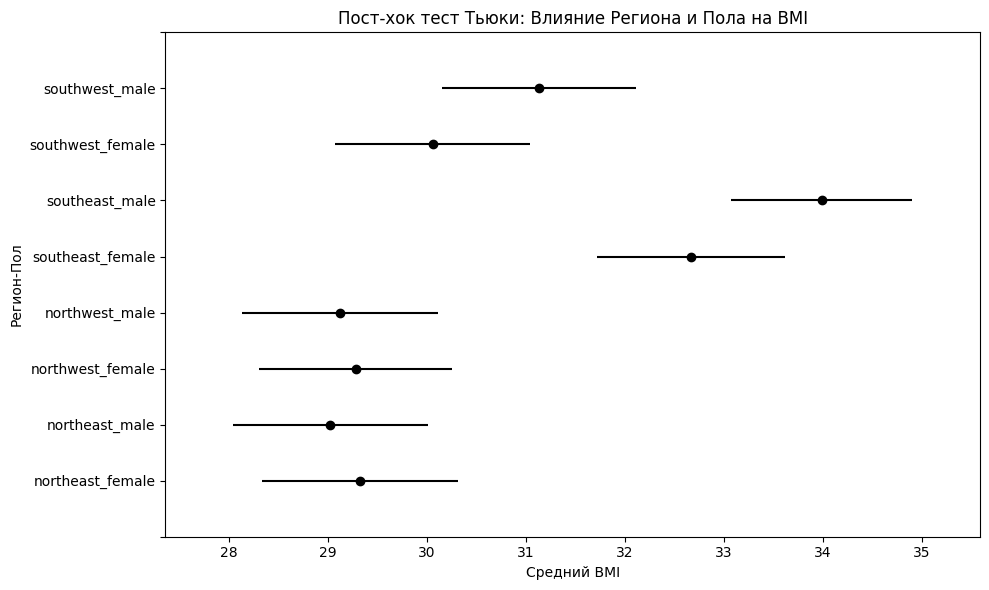

In [24]:
df['region_sex'] = df['region'] + '_' + df['sex']
tukey_twoway_result = pairwise_tukeyhsd(endog=df['bmi'], groups=df['region_sex'], alpha=alpha)
print("Пост-хок тест Тьюки (Двухфакторный):")
print(tukey_twoway_result.summary())

plt.figure(figsize=(12, 7))
tukey_twoway_result.plot_simultaneous(xlabel='Средний BMI', ylabel='Регион-Пол')
plt.title("Пост-хок тест Тьюки: Влияние Региона и Пола на BMI")
plt.tight_layout()
plt.show()

# Вывод

1. Влияние пола на BMI не является статистически значимым ни в целом (по двухфакторному ANOVA), ни при попарном сравнении внутри регионов (по тесту Тьюки).
2. Различия в BMI обусловлены, главным образом, тем, что BMI в регионе southeast статистически значимо выше, чем в остальных регионах, независимо от пола.
3. Несмотря на общую незначимость пола, тест Тьюки выявил, что средний BMI мужчин в southwest значимо отличается от среднего BMI мужчин в northeast и northwest (хотя разность средних невелика). Это может быть случайным артефактом или намеком на очень слабое взаимодействие, которое не было уловлено общим $F$-тестом ANOVA.